In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
import pickle


In [209]:
demand_features = ["eic_count",
"temperature",
"rain",
"surface_pressure",
"cloudcover_total",
"cloudcover_low",
"cloudcover_mid",
"windspeed_10m",
"diffuse_radiation",
"lowest_price_per_mwh",
"euros_per_mwh",
"24h_forecasted_10_metre_u_wind_component",
"24h_forecasted_10_metre_v_wind_component",
"24h_forecasted_direct_solar_radiation",
"diff_demand",
"hour",
"day",
"target_production",
"capacity_per_eic",
"Weekday"]


supply_features = ["eic_count",
"temperature",
"rain",
"surface_pressure",
"cloudcover_total",
"cloudcover_low",
"cloudcover_mid",
"cloudcover_high",
"windspeed_10m",
"diffuse_radiation",
"lowest_price_per_mwh",
'euros_per_mwh',
"24h_forecasted_cloudcover_high",
"24h_forecasted_cloudcover_low",
"24h_forecasted_10_metre_u_wind_component",
"24h_forecasted_10_metre_v_wind_component",
"24h_forecasted_direct_solar_radiation",
"diff_supply",
"hour",
"target_production"]

## Feature Engineering

In [210]:
df = pd.read_parquet("../data/processed/ENEFIT_dataset.parquet")
df['hour'] = df.index.hour
df['month'] = df.index.month
df['day'] = df.index.weekday + 1
df['target_production'] = df['installed_capacity'] * df['direct_solar_radiation'] / (df['temperature'] + 273.15)
df["capacity_per_eic"] = np.round(df["installed_capacity"] / df["eic_count"], 2)
df['Weekday'] = [0 if day > 4 else 1 for day in df.index.dayofweek]
df['Weekday'] = df['Weekday'].astype('int64')  # Explicitly cast to int64

In [211]:
def split_series(df, n_past, n_future, target_column_name, feature_column_names):
    """
    Split a DataFrame into past features and future target arrays.

    Parameters:
    - df: DataFrame containing the time series data.
    - n_past: Number of past observations to use for predicting the future.
    - n_future: Number of future observations to predict.
    - target_column_name: Name of the target column.
    - feature_column_names: List of column names to be used as features.
    - scaling: if dataset is scaled REMOVED

    Returns:
    - X: Array of past observations' features.
    - y: Array of future observations' target values.
    Only if scaling is true:
    - feature_scaler: scaler for X REMOVED
    - target_scaler: scaler for y REMOVED
    """

    # if scaling == 1:
    #     feature_scaler = MinMaxScaler()
    #     target_scaler = MinMaxScaler()
        
    #     # Fit the scalers
    #     feature_scaler.fit(df[feature_column_names])
    #     target_scaler.fit(df[[target_column_name]])
        
    #     # Apply the transformations
    #     scaled_features = feature_scaler.transform(df[feature_column_names])
    #     scaled_target = target_scaler.transform(df[[target_column_name]])

    X, y = list(), list()
    for window_start in range(len(df)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(df):
            break
        # Select the columns by name for the past and future segments
        # if scaling == 1:
        #     past = scaled_features[window_start:past_end]
        #     future = scaled_target[past_end:future_end]
        past = df.iloc[window_start:past_end][feature_column_names].values
        future = df.iloc[past_end:future_end][target_column_name].values
        X.append(past)
        y.append(future)
    X, y = np.array(X), np.array(y)
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    # if scaling == 1:
    #     return X, y, feature_scaler, target_scaler
    return X, y

def reformat_predictions_actual(pred, org_X_train):
       '''
       Converts the diff predictions into the original values, returns actual predictions and original values
       y_train[1:,:] + org_y_train[0:-1,:] == org_y_train[1]
       '''
       final_predictions = np.zeros_like(pred)

       for i in range(pred.shape[0]):
              final_predictions[i, 0] = org_X_train[i,-1] + pred[i,0]
              for j in range(1, pred.shape[1]):
                     final_predictions[i, j] = final_predictions[i, j-1] + pred[i, j]
       return final_predictions

## DEMAND FORECAST

In [212]:

n_past = 24
n_future = 24
target_column_name = 'diff_demand'
train_df, val_df, test_df = df[1:int(len(df)*0.7)], df[int(len(df)*0.7):int(len(df)*0.7)+int(len(df)*0.15)], df[int(len(df)*0.7)+int(len(df)*0.15):] 
feature_column_names = demand_features

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])
scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

ARIMA_X_train, ARIMA_y_train = split_series(train_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_val, ARIMA_y_val = split_series(val_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_test, ARIMA_y_test = split_series(test_df,n_past, n_future, target_column_name, target_column_name)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'demand', 'demand')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'demand', 'demand')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'demand', 'demand')

X shape: (10614, 24, 20), y shape: (10614, 24)
X shape: (2237, 24, 20), y shape: (2237, 24)
X shape: (2239, 24, 20), y shape: (2239, 24)
X shape: (10614, 24, 20), y shape: (10614, 24)
X shape: (2237, 24, 20), y shape: (2237, 24)
X shape: (2239, 24, 20), y shape: (2239, 24)
X shape: (10614, 24), y shape: (10614, 24)
X shape: (2237, 24), y shape: (2237, 24)
X shape: (2239, 24), y shape: (2239, 24)
X shape: (10614, 24), y shape: (10614, 24)
X shape: (2237, 24), y shape: (2237, 24)
X shape: (2239, 24), y shape: (2239, 24)


: 

In [179]:
org_results = {"train": org_X_train, "val": org_X_val, "test": org_X_test}

In [180]:
with open("../results/demand_org_results.pkl", "wb") as outfile: 
    pickle.dump(org_results, outfile)

### RANDOM FOREST

In [181]:
from sklearn.ensemble import RandomForestRegressor

X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

best_params = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 650, 700, 750, 800],  
    'max_features': [0.1, float(1/3), 2*float(1/3), 1] 
}

oob_errors = []
for n_estimators in best_params['n_estimators']:
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features = float(1/3),
        oob_score=True,
        random_state=42)
    rf.fit(X_train_flat, y_train)
    oob_error = 1 - rf.oob_score_
    oob_errors.append(oob_error)
    print(f'{n_estimators} trees: OOB error = {oob_error}')

optimal_n_estimators = best_params['n_estimators'][oob_errors.index(min(oob_errors))]

optimal_n_estimators = 500

plt.figure(figsize=(10, 6))
plt.plot(best_params['n_estimators'], oob_errors, '-o', label='OOB Error Rate')
plt.title('OOB Error Rate vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('OOB Error Rate')
plt.grid(True)
plt.legend()
plt.show()

optimal_feature = None
min_val_error = float('inf')
for max_f in best_params['max_features']:
    rf = RandomForestRegressor(
        n_estimators=optimal_n_estimators,
        max_features = max_f,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_flat, y_train)
    val_pred = rf.predict(X_val_flat)
    val_error = mean_squared_error(y_val, val_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        optimal_feature = max_f
    print(f'Max max_features = {max_f}: Validation MSE = {val_error}')

print(f'Optimal  max_features: {optimal_feature}')

In [182]:
rfmodel = RandomForestRegressor(
        n_estimators=500,
        max_features=0.33333,
        random_state=42,
        n_jobs=-1
    )
rfmodel.fit(X_train_flat, y_train)

RandomForestRegressor(max_features=0.33333, n_estimators=500, n_jobs=-1,
                      random_state=42)

In [183]:
train_pred = rfmodel.predict(X_train_flat)
val_pred = rfmodel.predict(X_val_flat)
test_pred = rfmodel.predict(X_test_flat)

rf_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
rf_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
rf_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

In [184]:
rf_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": rf_y_train_pred, "formatted_val":rf_y_val_pred, "formatted_test": rf_y_test_pred}

In [185]:
with open("../results/demand_rf_results.pkl", "wb") as outfile: 
    pickle.dump(rf_results, outfile)

### CNN-LSTM

In [186]:
import tensorflow as tf
from keras.layers import Bidirectional, Dense, Conv1D,MaxPooling1D, Dropout, LSTM, ReLU, Flatten, TimeDistributed, RepeatVector, LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_lstm_model(X, y):
    tf.random.set_seed(22)
    
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add((Conv1D(filters=64, kernel_size=3, padding='valid', input_shape= (X.shape[1],X.shape[2]))))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=32, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=16, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(Dropout(0.25))

    cnn_lstm_model.add(Flatten())

    cnn_lstm_model.add(RepeatVector(y.shape[1]))

    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Flatten())
    cnn_lstm_model.add(RepeatVector(y.shape[1]))
    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(TimeDistributed(Dense(1)))
    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)


In [187]:
cnn_lstm_model = build_lstm_model(scaled_X_train,scaled_y_train)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 22, 64)            3904      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 11, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 9, 32)             6176      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 4, 32)             0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 2, 16)             1552      
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 1, 16)            

In [188]:
with tf.device('cpu:0'): #my mac gpu sucks and trains really slow for some reason
    training_history = cnn_lstm_model.fit(scaled_X_train,scaled_y_train, epochs=100, batch_size=64, validation_data=(scaled_X_val, scaled_y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/100
166/166 [==============================] - 74s 421ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 2/100
166/166 [==============================] - 67s 401ms/step - loss: 0.0036 - val_loss: 0.0057
Epoch 3/100
166/166 [==============================] - 61s 366ms/step - loss: 0.0036 - val_loss: 0.0057
Epoch 4/100
166/166 [==============================] - 60s 361ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 5/100
166/166 [==============================] - 59s 353ms/step - loss: 0.0035 - val_loss: 0.0054
Epoch 6/100
166/166 [==============================] - 59s 356ms/step - loss: 0.0035 - val_loss: 0.0051
Epoch 7/100
166/166 [==============================] - 59s 353ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 8/100
166/166 [==============================] - 59s 355ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 9/100
166/166 [==============================] - 60s 360ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 10/100
166/166 [==============================] - 53s 322m

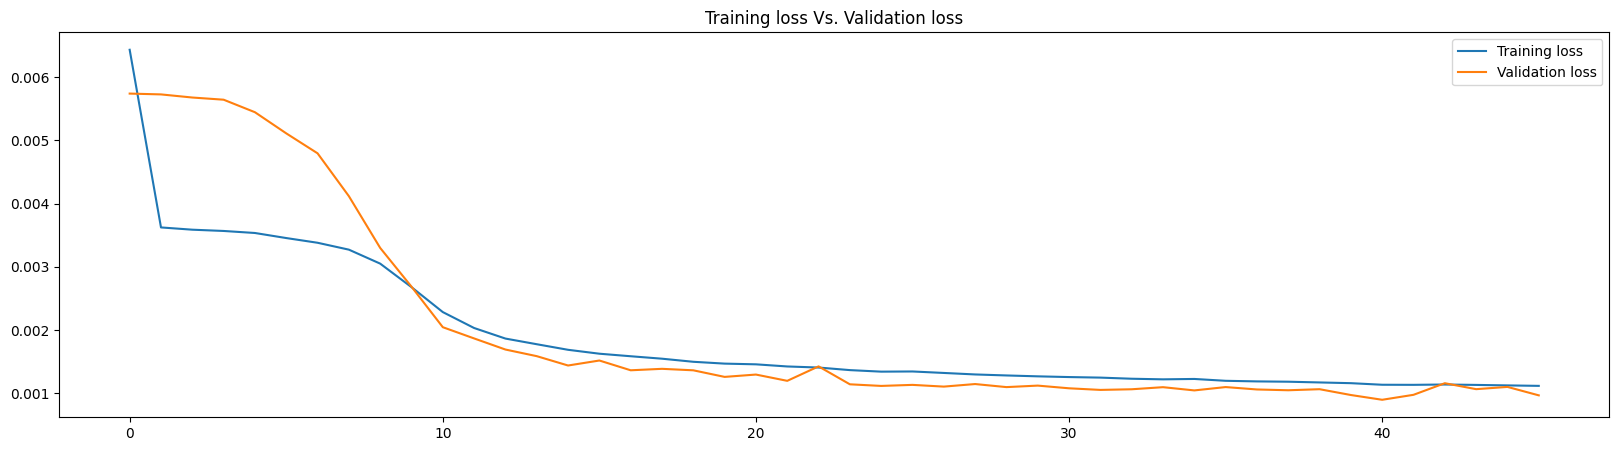

In [189]:
plt.figure(figsize=(20,5))
plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss')
plt.legend()

In [190]:
train_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_train).reshape(y_train.shape))
val_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_val).reshape(y_val.shape))
test_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_test).reshape(y_test.shape))
nn_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
nn_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
nn_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

70/70 [==============================] - 19s 273ms/step


In [191]:
nn_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": nn_y_train_pred, "formatted_val":nn_y_val_pred, "formatted_test": nn_y_test_pred}

In [192]:
with open("../results/demand_nn_results.pkl", "wb") as outfile: 
    pickle.dump(nn_results, outfile)

## SOLAR FORECAST

In [193]:
n_past = 24
n_future = 24
target_column_name = 'diff_supply'
# train_df, val_df, test_df = df[1:int(len(df)*0.8)], df[int(len(df)*0.8):int(len(df)*0.8)+int(len(df)*0.1)], df[int(len(df)*0.8)+int(len(df)*0.1):] 
train_df, val_df, test_df = df[1:int(len(df)*0.7)], df[int(len(df)*0.7):int(len(df)*0.7)+int(len(df)*0.15)], df[int(len(df)*0.7)+int(len(df)*0.15):] 
feature_column_names = supply_features
# feature_column_names = ['target', 'eic_count','forecasted_temperature','forecasted_direct_solar_radiation','forecasted_surface_solar_radiation_downwards','hour','month','day']

dataframe_scaler = MinMaxScaler()
dataframe_scaler = dataframe_scaler.fit(train_df)
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(train_df[[target_column_name]])
scaled_train_df = pd.DataFrame(dataframe_scaler.transform(train_df), columns = train_df.columns)
scaled_val_df = pd.DataFrame(dataframe_scaler.transform(val_df), columns = val_df.columns)
scaled_test_df = pd.DataFrame(dataframe_scaler.transform(test_df), columns = test_df.columns)

scaled_X_train, scaled_y_train = split_series(scaled_train_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_val, scaled_y_val = split_series(scaled_val_df,n_past, n_future, target_column_name, feature_column_names)
scaled_X_test, scaled_y_test = split_series(scaled_test_df,n_past, n_future, target_column_name, feature_column_names)

X_train, y_train = split_series(train_df,n_past, n_future, target_column_name, feature_column_names)
X_val, y_val = split_series(val_df,n_past, n_future, target_column_name, feature_column_names)
X_test, y_test = split_series(test_df,n_past, n_future, target_column_name, feature_column_names)

ARIMA_X_train, ARIMA_y_train = split_series(train_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_val, ARIMA_y_val = split_series(val_df,n_past, n_future, target_column_name, target_column_name)
ARIMA_X_test, ARIMA_y_test = split_series(test_df,n_past, n_future, target_column_name, target_column_name)

org_X_train, org_y_train = split_series(train_df,n_past, n_future, 'supply', 'supply')
org_X_val, org_y_val = split_series(val_df,n_past, n_future, 'supply', 'supply')
org_X_test, org_y_test = split_series(test_df,n_past, n_future, 'supply', 'supply')

X shape: (10614, 24, 20), y shape: (10614, 24)
X shape: (2237, 24, 20), y shape: (2237, 24)
X shape: (2239, 24, 20), y shape: (2239, 24)
X shape: (10614, 24, 20), y shape: (10614, 24)
X shape: (2237, 24, 20), y shape: (2237, 24)
X shape: (2239, 24, 20), y shape: (2239, 24)
X shape: (10614, 24), y shape: (10614, 24)
X shape: (2237, 24), y shape: (2237, 24)
X shape: (2239, 24), y shape: (2239, 24)
X shape: (10614, 24), y shape: (10614, 24)
X shape: (2237, 24), y shape: (2237, 24)
X shape: (2239, 24), y shape: (2239, 24)


In [194]:
org_results = {"train": org_X_train, "val": org_X_val, "test": org_X_test}

In [195]:
with open("../results/supply_org_results.pkl", "wb") as outfile: 
    pickle.dump(org_results, outfile)

### RANDOM FOREST

In [196]:
from sklearn.ensemble import RandomForestRegressor

X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

best_params = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 650, 700, 750, 800],  
    'max_features': [0.1, float(1/3), 2*float(1/3), 1] 
}

oob_errors = []
for n_estimators in best_params['n_estimators']:
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features = float(1/3),
        oob_score=True,
        random_state=42)
    rf.fit(X_train_flat, y_train)
    oob_error = 1 - rf.oob_score_
    oob_errors.append(oob_error)
    print(f'{n_estimators} trees: OOB error = {oob_error}')

optimal_n_estimators = best_params['n_estimators'][oob_errors.index(min(oob_errors))]

plt.figure(figsize=(10, 6))
plt.plot(best_params['n_estimators'], oob_errors, '-o', label='OOB Error Rate')
plt.title('OOB Error Rate vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('OOB Error Rate')
plt.grid(True)
plt.legend()
plt.show()

optimal_n_estimators = 500

optimal_feature = None
min_val_error = float('inf')
for max_f in best_params['max_features']:
    rf = RandomForestRegressor(
        n_estimators=optimal_n_estimators,
        max_features = max_f,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_flat, y_train)
    val_pred = rf.predict(X_val_flat)
    val_error = mean_squared_error(y_val, val_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        optimal_feature = max_f
    print(f'Max max_features = {max_f}: Validation MSE = {val_error}')

print(f'Optimal  max_features: {optimal_feature}')

In [197]:
rfmodel = RandomForestRegressor(
        n_estimators=500,
        max_features=0.3333,
        random_state=42,
        n_jobs=-1
    )
rfmodel.fit(X_train_flat, y_train)

RandomForestRegressor(max_features=0.3333, n_estimators=500, n_jobs=-1,
                      random_state=42)

In [198]:
train_pred = rfmodel.predict(X_train_flat)
val_pred = rfmodel.predict(X_val_flat)
test_pred = rfmodel.predict(X_test_flat)

rf_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
rf_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
rf_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

In [199]:
rf_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": rf_y_train_pred, "formatted_val":rf_y_val_pred, "formatted_test": rf_y_test_pred}

In [200]:
with open("../results/supply_rf_results.pkl", "wb") as outfile: 
    pickle.dump(rf_results, outfile)

### CNN-LSTM

In [201]:
import tensorflow as tf
from keras.layers import Bidirectional, Dense, Conv1D,MaxPooling1D, Dropout, LSTM, ReLU, Flatten, TimeDistributed, RepeatVector, LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_lstm_model(X, y):
    tf.random.set_seed(22)
    
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add((Conv1D(filters=64, kernel_size=3, padding='valid', input_shape= (X.shape[1],X.shape[2]))))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=32, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add((Conv1D(filters=16, kernel_size=3, padding='valid')))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(Dropout(0.25))

    cnn_lstm_model.add(Flatten())

    cnn_lstm_model.add(RepeatVector(y.shape[1]))

    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Flatten())
    cnn_lstm_model.add(RepeatVector(y.shape[1]))
    cnn_lstm_model.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(TimeDistributed(Dense(1)))
    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)


In [202]:
cnn_lstm_model = build_lstm_model(scaled_X_train,scaled_y_train)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 22, 64)            3904      
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 11, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, 9, 32)             6176      
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 4, 32)             0         
 ng1D)                                                           
                                                                 
 conv1d_17 (Conv1D)          (None, 2, 16)             1552      
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 1, 16)            

In [203]:
with tf.device('cpu:0'): #my mac gpu sucks and trains really slow for some reason
    training_history = cnn_lstm_model.fit(scaled_X_train,scaled_y_train, epochs=100, batch_size=64, validation_data=(scaled_X_val, scaled_y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/100
166/166 [==============================] - 53s 299ms/step - loss: 0.0195 - val_loss: 8.9124e-04
Epoch 2/100
166/166 [==============================] - 50s 300ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 3/100
166/166 [==============================] - 50s 302ms/step - loss: 0.0068 - val_loss: 8.2587e-04
Epoch 4/100
166/166 [==============================] - 51s 305ms/step - loss: 0.0051 - val_loss: 8.2282e-04
Epoch 5/100
166/166 [==============================] - 50s 303ms/step - loss: 0.0042 - val_loss: 5.7667e-04
Epoch 6/100
166/166 [==============================] - 50s 301ms/step - loss: 0.0038 - val_loss: 5.8442e-04
Epoch 7/100
166/166 [==============================] - 50s 301ms/step - loss: 0.0036 - val_loss: 4.8489e-04
Epoch 8/100
166/166 [==============================] - 50s 299ms/step - loss: 0.0033 - val_loss: 4.5018e-04
Epoch 9/100
166/166 [==============================] - 50s 299ms/step - loss: 0.0032 - val_loss: 4.9923e-04
Epoch 10/100
166/166 [==========

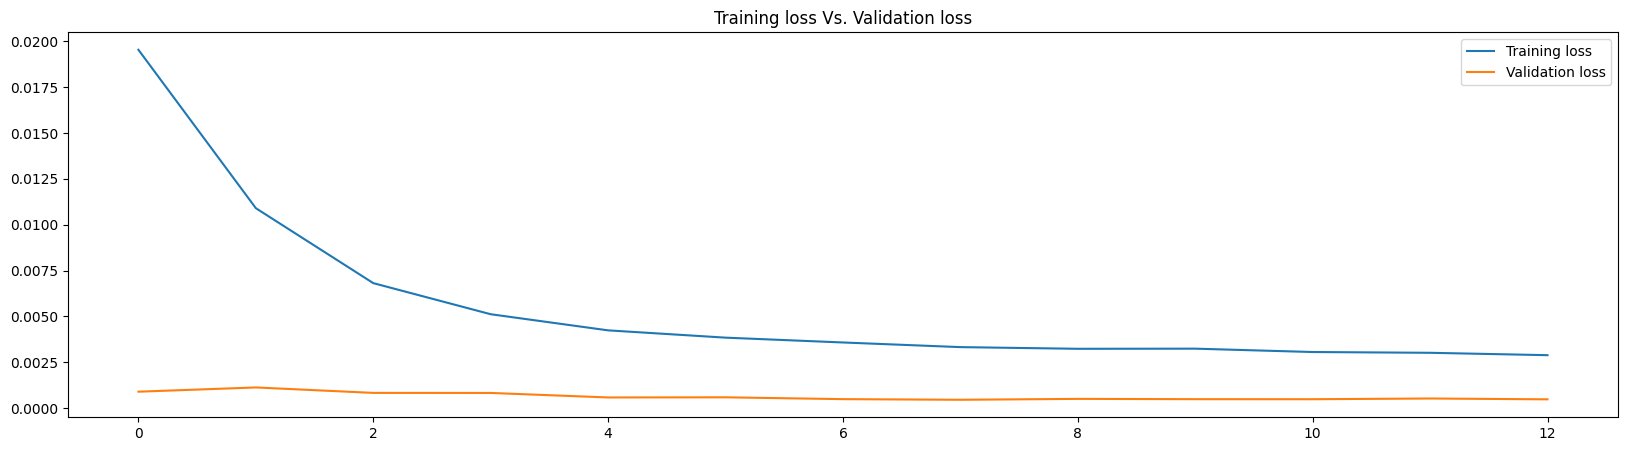

In [204]:
plt.figure(figsize=(20,5))
plt.plot(training_history.history['loss'], label='Training loss')
plt.plot(training_history.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss')
plt.legend()

In [205]:
train_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_train).reshape(y_train.shape))
val_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_val).reshape(y_val.shape))
test_pred = inverse_scaler.inverse_transform(cnn_lstm_model.predict(scaled_X_test).reshape(y_test.shape))
nn_y_train_pred = reformat_predictions_actual(train_pred, org_X_train)
nn_y_val_pred = reformat_predictions_actual(val_pred, org_X_val)
nn_y_test_pred = reformat_predictions_actual(test_pred, org_X_test)

70/70 [==============================] - 19s 272ms/step


In [206]:
nn_results = {"train": train_pred, "val": val_pred, "test": test_pred, "formatted_train": nn_y_train_pred, "formatted_val":nn_y_val_pred, "formatted_test": nn_y_test_pred}

In [207]:
with open("../results/supply_nn_results.pkl", "wb") as outfile: 
    pickle.dump(nn_results, outfile)